## Imperfect Tests and The Effects of False Positives

The US government has been widely criticized for its failure to test as many of its citizens for COVID-19 infections as other countries. But is mass testing really as easy as it seems? This analysis of the false positive and false negative rates of tests, using published sensitivities and specificities for COVID-19 rt-PCR and antigen tests, shows that even tests with slightly less than perfect results can produce very large numbers of false positives. 

In [1]:
import sys
# Install required packages
#!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

As the world became more aware of the threat posed by COVID-19 in February 2020, US media began to draw attention to the disparity between the extent of testing being done in other countries versus the United States. The CDC released [fairly restrictive guidelines](https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-criteria.html) for what conditions qualified a patient for a lab test for COVID-19 infections, and many media outlets criticized the US CDC for being unprepared to test for the virus. 

Criticism intensified when the first version of tests created by the CDC [proved to be unreliable](https://www.forbes.com/sites/rachelsandler/2020/03/02/how-the-cdc-botched-its-initial-coronavirus-response-with-faulty-tests/#5bbf1d50670e). But there are important considerations that these reports have largely ignored, the most important of which is the false positive and false negative rates of the tests, which can produce results that are worse than useless when the prevalence of the condition — the percentage of people who are infected — is very low.

Every test — for nearly any sort of test — has an error rate: false positives and false negatives. False negatives are fairly easy to understand. If a 1,000 women who have breast cancer take a test that has a false positive rate of 1%, the test will report that 999 of them have cancer, and 1 who does not, even though she actually does.

The false positive rate is trickier, because it is multipled not by the number of women who have cancer, but by the number of women who take the test. If the situation is that a large number of women are tested, but few have cancer, the test can report many more false positives than women who actually have cancer. 

There is evidence that the tests for the COVID-19 virus have a false positive rate large enough that if a large number of people are tested when the prevalence of COVID-19 infections are small, most of the reported positives are false positives. 


# Primer on False Positives and Negatives

Research related to epidemiological tests typically does not report the false positive rate directly; instead it reports two parameters, the Selectivity and Specificity. [Wikipedia has an excellent article](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) describing these parameters and how they related to false positive and false negative rates, and [Health News Review](https://www.healthnewsreview.org/) publishes this [very accessible overview of the most important concepts](https://www.healthnewsreview.org/toolkit/tips-for-understanding-studies/understanding-medical-tests-sensitivity-specificity-and-positive-predictive-value/).  The most important part of the Wikipedia article to understand is the table in the [worked example](https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Worked_example). When a test is administered, there are four possible outcomes. The test can return a positive result, which can be a true positive or a false positive, or it can return a negative result, which is a true negative or a false negative. If you organize those posibilities by what is the true condition ( does the patient have the vius or not ):

* Patient has virus
 * True Positive ($\mathit{TP}$)
 * False negative ($\mathit{FN}$)
* Patient does not have virus
 * True Negative ($\mathit{TN}$)
 * False Positive.  ($\mathit{FP}$)

In the Wikipedia worked example table:

* The number of people who do have the virus is $\mathit{TP}+\mathit{FN}$, the true positives plus the false negatives, which are the cases that should have been reported positive, but were not. 
* The number of people who do not have the virus is $\mathit{TN}+\mathit{FP}$, the true negatives and the false positives, which are the cases should have been reported positive, but were not. 

The values of Sensitivity and Specificity are defined as: 

$$\begin{array}{ll}
Sn = \frac{\mathit{TP}}{\mathit{TP} + \mathit{FN}} & \text{True positives outcomes divided by all positive conditions} \tag{1}\label{eq1}\\ 
Sp = \frac{\mathit{TN}}{\mathit{FP} + \mathit{TN}} & \text{True negatives outcomes divided by all negative conditions}\\ 
\end{array}$$

We want to know the number of false positives($\mathit{FP}$) given the number of positive conditions ($\mathit{TP}+\mathit{FN}$) and the total number of tests. To compute these, we need to have some more information about the number of people tested, and how common the disease is: 

* Total test population $P$, the number of people being tested, which equals $\mathit{TP}+\mathit{FP}+\mathit{FN}+\mathit{TN}$
* The prevalence $p$, the population rate of positive condition. 

We can do a little math to get: 

$$\begin{array}{ll}
\mathit{TP} = Pp\mathit{Sn} & \text{}\\ 
\mathit{FP} = P(1-p)(1-\mathit{Sp}) \text{}\\ 
\mathit{TN} = P(1-p)\mathit{Sp} & \text{}\\ 
\mathit{FN} = Pp(1-\mathit{Sn})& \text{}\\ 
\end{array}$$

You can see examples of these equations worked out in the third line in the red and green cells of the [Worked Example](https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Worked_example) on the Sensitivity and Specificity Wikipedia page. 

It is important to note that when these four values are used to calculate $\mathit{Sp}$ and $\mathit{Sn}$, the population value $P$ cancels out, so $\mathit{Sp}$ and $\mathit{Sn}$ do not depend on the number of people tested. 



One of the interesting questions when test results are reported is "What percentage of the positive results are true positives?" This is a particularly important question for the COVID-19 pandemic because there are a lot of reports that most people with the virus are asymptomatic. Are they really asymptomatic, or just false positives?

The metric we're interested here is the portion of positive results that are true positives, the positive predictive value, $\mathit{PPV}$:

$$\mathit{PPV} = \frac{\mathit{TP} }{ \mathit{TP} +\mathit{FP}  } $$

Which expands to:

$$\mathit{PPV} = \frac{p\mathit{Sn} }{ p\mathit{Sn} + (1-p)(1-\mathit{Sp})  }\tag{2}\label{eq2} $$

It is important to note that $\mathit{PPV}$ is not dependent on $P$, the size of the population being tested. It depends only on the quality parameters of the test, $\mathit{Sn}$ and $\mathit{Sp}$, and the prevalence, $p$. For a given test, only the prevalence will change over time. 

# Selctivity and Specificity Values

It has been dificult to find specificity and sensitivity values for COVID-19 tests, or any rt-PCR tests; research papers rarely publish the values. Howver, there are a few reports for the values for serology tests, and a few reports of values for rt-PRC tests for the MERS-CoV virus. 

We can get values for an antibidy test for COVID-19 from a a recently published paper, _Development and Clinical Application of A Rapid IgM-IgG Combined Antibody Test for SARS-CoV-2 Infection Diagnosis_<sup><a href="#fnote2" rel="noopener" target="_self">2</a></sup>, which reports: 

> The overall testing sensitivity was 88.66% and specificity was 90.63%

This test is significantly different from the most common early tests for COVID-19; this test looks for antibodies in the patient's blood, while most COVID-19 tests are rt-PCR assays that look for fragments of RNA from the virus. 

The article _MERS-CoV diagnosis: An update._<sup><a href="#fnote4" rel="noopener" target="_self">4</a></sup> reports that for MERS-CoV:

> Song et al. developed a rapid immunochromatographic assay for the detection of MERS-CoV nucleocapsid protein from camel nasal swabs with 93.9% sensitivity and 100% specificity compared to RT-rtPCR

The article _Performance Evaluation of the PowerChek MERS (upE & ORF1a) Real-Time PCR Kit for the Detection of Middle East Respiratory Syndrome Coronavirus RNA_<sup><a href="#fnote5" rel="noopener" target="_self">5</a></sup> reports:

> The diagnostic sensitivity and specificity of the PowerChek MERS assay were both 100% (95% confidence interval, 91.1–100%).

The [Emergency Use Authorization for LabCorp's rt-PCR test](https://www.fda.gov/media/136151/download)<sup><a href="#fnote6" rel="noopener" target="_self">6</a></sup> reports:

~~~
Performance of the COVID-19 RT-PCR test against the expected results [ with NP swabs ] are:
Positive Percent Agreement 40/40 = 100% (95% CI: 91.24%-100%)
Negative Percent Agreement 50/50 = 100% (95% CI: 92.87% -100%)
~~~

Using the lower bound of the 95% CI,  values convert to a specificity of .90  and sensitivity of .94.

A recent report characterizes Abbott Labs ID NOW system, used for influenza tests. [Abbott Labs recieved an EUA](https://www.fda.gov/media/136525/download), on 27 March 2020, for a version of the device for use with COVID-19. The study of the the influenza version states:

> The sensitivities of ID NOW 2 for influenza A were 95.9% and 95.7% in NPS and NPA, respectively, and for influenza B were 100% and 98.7% in NPS and NPA, respectively. The specificity was 100% for both influenza A and influenza B in NPS and NPA. 

The results section of the paper provides these parameters, when compared to rRT-PCR: 

<table>
    <tr>
        <th>Virus</th>
        <th>Parameter</th>
        <th>ID NOW 2</th>
        <th> ID NOW 2 VTM</th>
    </tr>
    <tr>
        <td>type A</td>
        <td>Sensitivity (95% CI)</td>
        <td>95.7 (89.2-98.8)</td>
        <td>96.7 (90.8-99.3)</td>
    </tr>
        <tr>
        <td></td>
        <td>Specificity (95% CI)</td>
        <td>100 (89.3-100) </td>
        <td>100 (89.3-100)</td>
    </tr>
        <tr>
        <td>Type B</td>
        <td>Sensitivity (95% CI)</td>
        <td>98.7 (93.0-100)</td>
        <td>100 (96.2-100)</td>
    </tr>
        <tr>
        <td></td>
        <td>Specificity (95% CI)</td>
        <td>100 (98.5-100)</td>
        <td>100 (98.5-100)</td>
    </tr>
 </table>
    
A recent Medscape article<a href="#fnote7" rel="noopener" target="_self">7</a></sup> on the specificity and sensitivity of Influenza tests reports: 

> In a study of the nucleic acid amplification tests ID Now (Abbott), Cobas Influenza A/B Assay (Roche Molecular Diagnostics), and Xpert Xpress Flu (Cepheid), Kanwar et al found the three products to have comparable sensitivities for influenza A (93.2%, 100%, 100%, respectively) and B (97.2%, 94.4%, 91.7%, respectively) detection. In addition, each product had greater than 97% specificity for influenza A and B detection. 

> Rapid antigen tests generally have a sensitivity of 50-70% and a specificity of 90-95%. Limited studies have demonstrated very low sensitivity for detection of 2009 H1N1 with some commercial brands. 




Based on these values, we'll explore the effects of sensitivity and specificities in the range of .9 to 1. 


# PPV For Serology Test

First we'll look at the positive prediction value for the antibody test in reference (<a href="#fnote2" rel="noopener" target="_self">2</a>), which has the lowest published Sp and Sn values at .9063 and .8866. The plot below shows the portion of positive test results that are true positives s a function of the prevalence. 


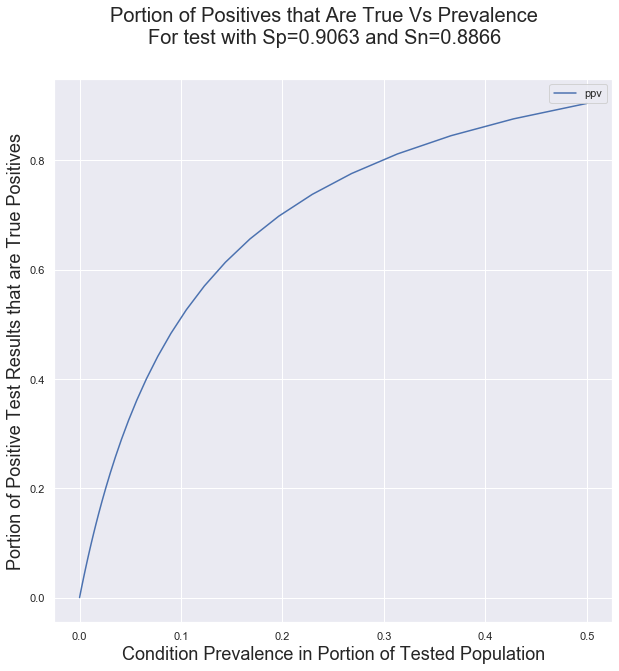

In [2]:
def p_vs_tpr(Sp, Sn):

    for p in np.power(10,np.linspace(-7,np.log10(.5), num=100)): # range from 1 per 10m to 50%
        ppv = (p*Sn) / ( (p*Sn)+(1-p)*(1-Sp))
        yield (p, ppv)

def plot_ppv(Sp, Sn):

    df = pd.DataFrame(list(p_vs_tpr(Sp, Sn)), columns='p ppv'.split())
    df.head()

    fig, ax = plt.subplots(figsize=(12,8))

    df.plot(ax=ax, x='p',y='ppv', figsize=(10,10))

    fig.suptitle(f'Portion of Positives that Are True Vs Prevalence\nFor test with Sp={Sp} and Sn={Sn}', fontsize=20)

    ax.set_xlabel('Condition Prevalence in Portion of Tested Population', fontsize=18)
    ax.set_ylabel('Portion of Positive Test Results that are True Positives', fontsize=18);


    #ax.set_xscale('log')
    #ax.set_yscale('log')
    
    
plot_ppv(Sp = .9063, Sn = .8866)


The important implication of this curve is that using a test with low Sp and Sn values in conditions of low prevalence will result in a very large portion of false positives.

# False Positives for LabCorp's test

Although the published results for the LabCorp test are 100% true positives and true negative rates, the 95% error margin is substantial, because the test was validatd with a relatively small number of samples. This analysis will use the published error margins to produce a distribution of positive prediction values. First, let's look at the distributions of the true positive and true negative rates, accounting for the published confidence intervals. These distributions are generated by converting the published true and false rates, and their CIs into gaussian distributions, and selecting only values that are 1 or lower from those distributions.


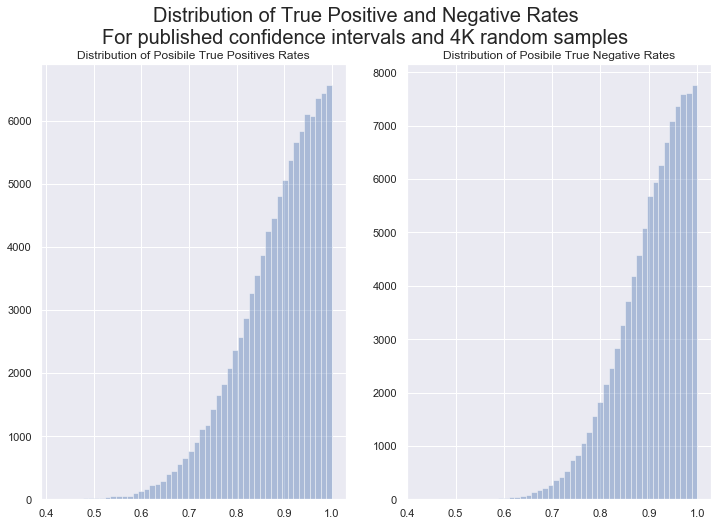

In [16]:
# Convert CI to standard error. The values are reported for a one-sided 95% CI, 
# so we're multiplying by the conversion for a two-sided 90% ci
p_se = (1-.9124) * 1.645 
n_se = (1-.9287) * 1.645 


def select_v(se):
    """get a distribution value, which must be less than or equal to 1"""
    while True:
        v = np.random.normal(1, se)
        if v <= 1:
            return v
        
    
# These values are not TP and FP counts; they are normalized to 
# prevalence
TP = np.array(list(select_v(p_se) for _ in range(100_000)))
TN = np.array(list(select_v(n_se) for _ in range(100_000)))

fig, ax = plt.subplots(1,2, figsize=(12,8))
sns.distplot( TP, ax=ax[0], kde=False);

ax[0].set_title('Distribution of Posibile True Positives Rates');

sns.distplot( TN, ax=ax[1], kde=False);

ax[1].set_title('Distribution of Posibile True Negative Rates');

fig.suptitle(f'Distribution of True Positive and Negative Rates'
             '\nFor published confidence intervals and 4K random samples', fontsize=20);


It is important to note that these are not the distributions 

From these distributions, we can calculate the distributions for the positive prediction value, the portion of all positive results that are true positives. 

With these distributions, we can use ([Eq 2](#MathJax-Span-5239)) to compute the distributions of PPV for a variety of prevalences. In each chart, the 'mean' is the expectation value of the distribution, the weighted mean of the values. It is the most likely PPV valule for the given prevalence. 

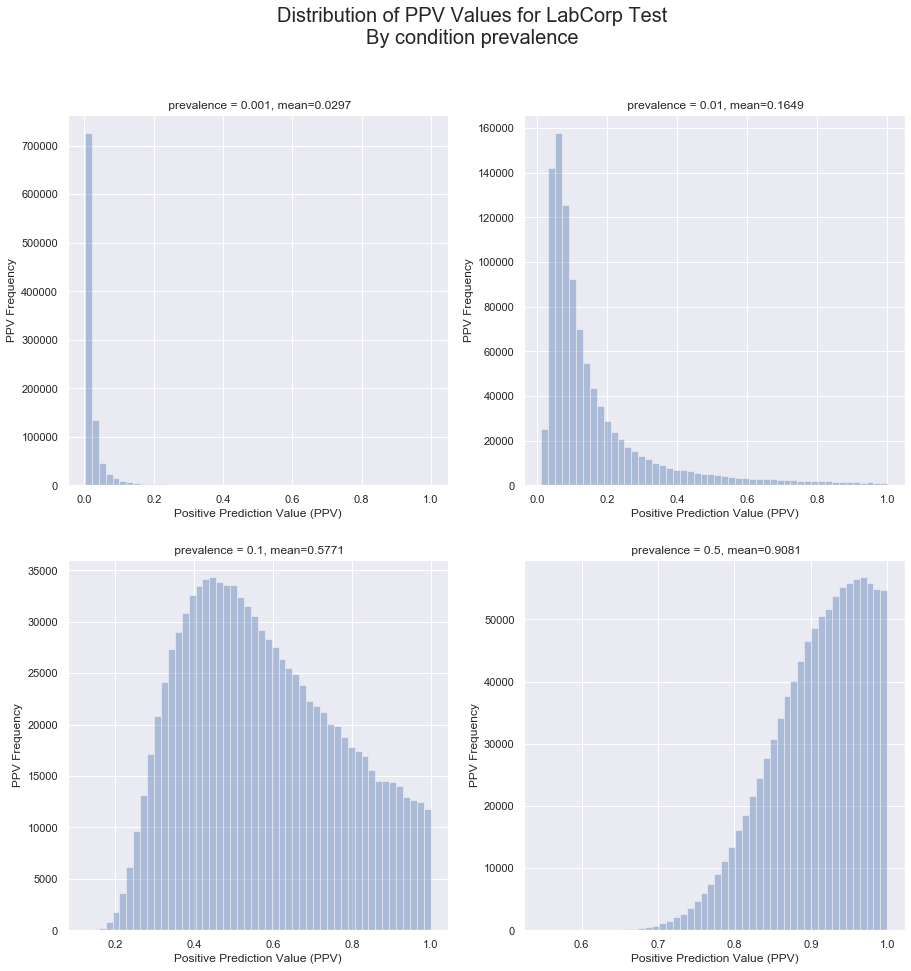

In [18]:
FP = 1-TN
FN = 1-TP

Sn = TP / (TP+FN)
Sp = TN / (TN+FP)

def ppv_dist_ufunc(p, Sp, Sn):
    return (p*Sn) / ( (p*Sn)+(1-p)*(1-Sp))

def ppv_dist(p, Sp, Sn):
    sp = np.random.choice(Sp, 1_000_000, replace=True)
    sn = np.random.choice(Sn, 1_000_000, replace=True)
    
    return ppv_dist_ufunc(p,sp, sn)
    
fig, axes = plt.subplots( 2,2, figsize=(15,15))
axes = axes.flat

def plot_axis(axn, prevalence):
    ppvd = ppv_dist(prevalence, Sp, Sn)
    wmean = (ppvd.sum()/len(ppvd)).round(4)
    sns.distplot( ppvd, ax=axes[axn], kde=False);
    axes[axn].set_title(f' prevalence = {prevalence}, mean={wmean}');
    axes[axn].set_xlabel('Positive Prediction Value (PPV)')
    axes[axn].set_ylabel('PPV Frequency')

plot_axis(0, .001)
plot_axis(1, .01)
plot_axis(2, .10)
plot_axis(3, .5)
    
fig.suptitle(f'Distribution of PPV Values for LabCorp Test\nBy condition prevalence', fontsize=20);


0.9062828889965551

The implication of these charts is that, even for a test with published true positive and true negative rate of 100%, the uncertainties in the measurements can mean that there still a substantial problem of false positives for low prevalences. 

Computing the mean PPV value or a range of prevalence values results in the following relationship.

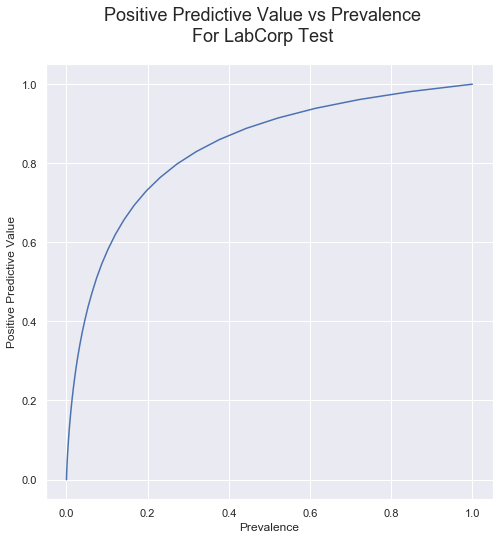

In [19]:
def ppv_vs_p():
    for p in np.power(10,np.linspace(-7,np.log10(1), num=100)): # range from 1 per 10m to 50%
        ppvd = ppv_dist(p, Sp, Sn)
        yield p, ppvd.sum()/len(ppvd)
        
ppv_v_p = pd.DataFrame(list(ppv_vs_p()), columns='p ppv'.split())

fig, ax = plt.subplots(figsize=(8,8))

sns.lineplot(x='p', y='ppv', data=ppv_v_p, ax=ax)
ax.set_xlabel('Prevalence')
ax.set_ylabel('Positive Predictive Value')

fig.suptitle("Positive Predictive Value vs Prevalence\nFor LabCorp Test", fontsize=18);

Compare this curve to the one presented earlier, for the antibody test with published sensitivity of 88.66% and specificity of 90.63%; The relationship between P and PPV for the rt-PCR test isn't much better. 

But what if the tests are really, really good: .99 for both sensitivity and specificity? Here is the curve for that case:


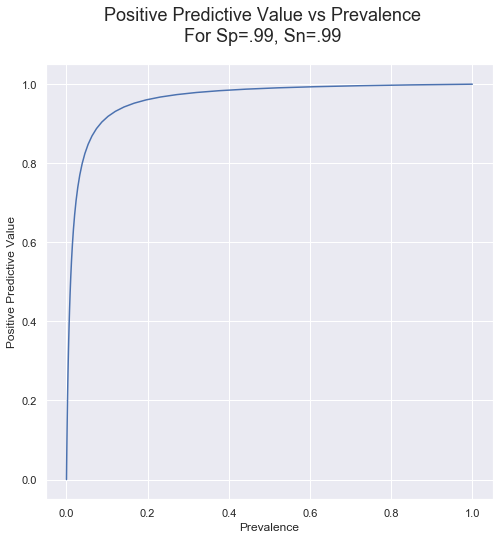

In [6]:
def ppv_vs_p():
    for p in np.power(10,np.linspace(-7,np.log10(1), num=100)): # range from 1 per 10m to 50%
        ppvd = ppv_dist_ufunc(p, .99, .99)
        yield p, ppvd
        
ppv_v_p = pd.DataFrame(list(ppv_vs_p()), columns='p ppv'.split())

fig, ax = plt.subplots(figsize=(8,8))

sns.lineplot(x='p', y='ppv', data=ppv_v_p, ax=ax)
ax.set_xlabel('Prevalence')
ax.set_ylabel('Positive Predictive Value')

fig.suptitle("Positive Predictive Value vs Prevalence\nFor Sp=.99, Sn=.99", fontsize=18);

This table shows the PPVs and false positive rate for a logrhythimic range of prevalences. 

In [7]:
prevs =  [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
names = ["1 per {}".format(round(1/p,0)) for p in prevs]
ppvs = [ppv_v_p.loc[(ppv_v_p.p-p).abs().idxmin()].ppv for p in prevs]
fp = [ str(round((1-ppv)*100,1))+"%" for ppv in ppvs]
df = pd.DataFrame({
    'Rate': names,
    'Prevalence': prevs,
    'PPV': ppvs,
    'False Positives Rate': fp
}).set_index('Prevalence')

df


,Rate,PPV,False Positives Rate
Prevalence,,,
0.000001,1 per 1000000.0,0.000097,100.0%
0.000010,1 per 100000.0,0.000944,99.9%
0.000100,1 per 10000.0,0.009149,99.1%
0.001000,1 per 1000.0,0.096060,90.4%
0.010000,1 per 100.0,0.511747,48.8%
0.100000,1 per 10.0,0.918622,8.1%


This case is much better, across the range of prevalences, but for low prevalence, there are still a lot of false positives, and below 1 per 1000, it is nearly all false positives. Here is the same chart, but for Sp and Sn at 99.99%

In [8]:
def ppv_vs_p():
    for p in np.power(10,np.linspace(-7,np.log10(1), num=100)): # range from 1 per 10m to 50%
        ppvd = ppv_dist_ufunc(p, .9999, .9999)
        yield p, ppvd
        
ppv_v_p = pd.DataFrame(list(ppv_vs_p()), columns='p ppv'.split())

ppvs = [ppv_v_p.loc[(ppv_v_p.p-p).abs().idxmin()].ppv for p in prevs]
fp = [ str(round((1-ppv)*100,1))+"%" for ppv in ppvs]
df = pd.DataFrame({
    'Rate': names,
    'Prevalence': prevs,
    'PPV': ppvs,
    'False Positives Rate': fp
}).set_index('Prevalence')

df



,Rate,PPV,False Positives Rate
Prevalence,,,
0.000001,1 per 1000000.0,0.009675,99.0%
0.000010,1 per 100000.0,0.087130,91.3%
0.000100,1 per 10000.0,0.482562,51.7%
0.001000,1 per 1000.0,0.914771,8.5%
0.010000,1 per 100.0,0.990642,0.9%
0.100000,1 per 10.0,0.999124,0.1%


Even a very accurate test will not be able to distinguish healthy from sick better than a coin flip if the prevalence is less than 1 per 10,000. 

# Conclusion

Tests with less than 100% specificity and selectivity, including those with published values of 100% but with a moderate confidence interval, are very sensitive to low condition prevalences. Considering the confidence intervals, to ensure that 50% of positive results are true positives requires a prevalence of about 10%, and 80% PPV requires about a 30% prevalence. This suggests that using rt-PCR tests to test a large population that has a low prevalence is likely to produce a large number of false positive results. 

# References 

* <a name="fnote1">1</a> Parikh, Rajul et al. “[Understanding and using sensitivity, specificity and predictive values.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2636062/)” Indian journal of ophthalmology vol. 56,1 (2008): 45-50. doi:10.4103/0301-4738.37595
* <a name="fnote2">2</a> Li, Zhengtu et al. “[Development and Clinical Application of A Rapid IgM-IgG Combined Antibody Test for SARS-CoV-2 Infection Diagnosis.](https://pubmed.ncbi.nlm.nih.gov/32104917/)” Journal of medical virology, 10.1002/jmv.25727. 27 Feb. 2020, doi:10.1002/jmv.25727
* <a name="fnote3">3</a> Zhuang, G H et al. “[Potential False-Positive Rate Among the 'Asymptomatic Infected Individuals' in Close Contacts of COVID-19 Patients](https://pubmed.ncbi.nlm.nih.gov/32133832)” Zhonghua liuxingbingxue zazhi, vol. 41,4 485-488. 5 Mar. 2020, doi:10.3760/cma.j.cn112338-20200221-00144
* <a name="fnote4">4</a> Al Johani, Sameera, and Ali H Hajeer. “[MERS-CoV diagnosis: An update.](https://www.sciencedirect.com/science/article/pii/S1876034116300223)” Journal of infection and public health vol. 9,3 (2016): 216-9. doi:10.1016/j.jiph.2016.04.005
* <a name="fnote5">5</a> Huh, Hee Jae et al. “[Performance Evaluation of the PowerChek MERS (upE & ORF1a) Real-Time PCR Kit for the Detection of Middle East Respiratory Syndrome Coronavirus RNA.](http://www.annlabmed.org/journal/view.html?volume=37&number=6&spage=494)” Annals of laboratory medicine vol. 37,6 (2017): 494-498. doi:10.3343/alm.2017.37.6.494
* <a name="fnote7">7</a> [Emergency Use Authorization summary](https://www.fda.gov/media/136151/download) for LabCorp's COVID-19 rt-PCR test. 
* Mitamura, Keiko et al. “[Clinical evaluation of ID NOW influenza A & B 2, a rapid influenza virus detection kit using isothermal nucleic acid amplification technology - A comparison with currently available tests.](https://pubmed.ncbi.nlm.nih.gov/31558351/?from_single_result=31558351)” Journal of infection and chemotherapy : official journal of the Japan Society of Chemotherapy vol. 26,2 (2020): 216-221. doi:10.1016/j.jiac.2019.08.015
* <a name="fnote7">8</a>  Blanco, E. M. (2020, January 22). [What is the sensitivity and specificity of diagnostic influenza tests?](https://www.medscape.com/answers/2053517-197226/what-is-the-sensitivity-and-specificity-of-diagnostic-influenza-tests) Retrieved March 27, 2020, from https://www.medscape.com/answers/2053517-197226/what-is-the-sensitivity-and-specificity-of-diagnostic-influenza-tests


## Supporting Web Articles

The World Health Organization has a [web page with links to information the COVID-19 tests](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/technical-guidance/laboratory-guidance) from many countries. 

The CDC's page for [Rapid Diagnostic Testing for Influenza: Information for Clinical Laboratory Directors](https://www.cdc.gov/flu/professionals/diagnosis/rapidlab.htm) describes the minimum specificity and sensitivity for rapid influenza diagnostic tests, and shows some examples of PPV and flase positive rates. 

Washington Post: [A ‘negative’ coronavirus test result doesn’t always mean you aren’t infected](https://www.washingtonpost.com/science/2020/03/26/negative-coronavirus-test-result-doesnt-always-mean-you-arent-infected/)

Prague Morning: [80% of Rapid COVID-19 Tests the Czech Republic Bought From China are Wrong](https://www.praguemorning.cz/80-of-rapid-covid-19-tests-the-czech-republic-bought-from-china-are-wrong/)

BusinessInsider: [Spain, Europe's worst-hit country after Italy, says coronavirus tests it bought from China are failing to detect positive cases](https://www.businessinsider.com/coronavirus-spain-says-rapid-tests-sent-from-china-missing-cases-2020-3?op=1)

Wikipedia has a good discussion of the false positives problem in the articl about the [Base Rate Falacy](https://en.wikipedia.org/wiki/Base_rate_fallacy#False_positive_paradox). 


## Other References

The following references were referenced by Blanco <a href="#fnote6" rel="noopener" target="_self">6</a></sup>, but I haven't evaluated them yet. 

Kanwar N, Michael J, Doran K, Montgomery E, Selvarangan R. Comparison of the ID NOWTM Influenza A & B 2, Cobas® Influenza A/B, and Xpert® Xpress Flu Point-of-Care Nucleic Acid Amplification Tests for Influenza A/B Detection in Children. J Clin Microbiol. 2020 Jan 15. 

Blyth CC, Iredell JR, Dwyer DE. Rapid-test sensitivity for novel swine-origin influenza A (H1N1) virus in humans. N Engl J Med. 2009 Dec 17. 361(25):2493. 

Evaluation of rapid influenza diagnostic tests for detection of novel influenza A (H1N1) Virus - United States, 2009. MMWR Morb Mortal Wkly Rep. 2009 Aug 7. 58(30):826-9. 

Faix DJ, Sherman SS, Waterman SH. Rapid-test sensitivity for novel swine-origin influenza A (H1N1) virus in humans. N Engl J Med. 2009 Aug 13. 361(7):728-9. 

Ginocchio CC, Zhang F, Manji R, Arora S, Bornfreund M, Falk L. Evaluation of multiple test methods for the detection of the novel 2009 influenza A (H1N1) during the New York City outbreak. J Clin Virol. 2009 Jul. 45(3):191-5. 

Sambol AR, Abdalhamid B, Lyden ER, Aden TA, Noel RK, Hinrichs SH. Use of rapid influenza diagnostic tests under field conditions as a screening tool during an outbreak of the 2009 novel influenza virus: practical considerations. J Clin Virol. 2010 Mar. 47(3):229-33. 


# Updates

* 2020-03-25: Changed conversion from CI to SE from 1.96 to 1.645; using the factor for a two sided 90% ci for the 95% one sided CI.
* 2020-03-27: Added parameters for Sp and Sn for the influenza version of Abbott Labs ID NOW device. 